# NIR Spectral Analysis with AS7263 
A clean, step-by-step notebook to:
1. Load & visualize spectral data
2. Preprocess inputs & encode outputs
3. Build & visualize Conv1D → MLP multi-output model
4. Train & plot learning curves
5. Evaluate & save final model

**Input include:**
- 6-dimensional Vector NIR Spectral: [610nm, 680nm, 730nm, 760nm, 810nm, 860nm]

**Outputs include:**
- °Brix (regression)
- Ripeness (regression)
- Moisture content (regression)
- Grade (A/B/C classification)
- Internal defect (Y/N)
- Disease or fungal infection (Y/N)

In [1]:
!pip install -q tensorflow
!pip install scikit-learn
!pip install seaborn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense
from tensorflow.keras.utils import plot_model



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Load Dataset & Initial Visualization

In [2]:
# Đường dẫn file CSV của bạn
csv_path = "data_nir/nir_spectral_dataset_augmented.csv"  # 🔁 thay nếu cần

# Đọc dữ liệu
df = pd.read_csv(csv_path)

# Hiển thị bảng dữ liệu
print("📊 Dữ liệu từ file CSV:")
df.head(200)  # Hiển thị 20 dòng đầu tiên

📊 Dữ liệu từ file CSV:


,610nm,680nm,730nm,760nm,810nm,860nm,fruit,brix,ripeness,moisture,grade,defect,fungus
0,0.547279,0.708255,0.616893,0.574339,0.697897,0.687423,mango,16.820563,8.698674,84.946064,A,0,0
1,0.526963,0.673391,0.614805,0.595130,0.690251,0.686795,mango,17.000327,9.656373,78.564644,A,1,0
2,0.617034,0.628717,0.607246,0.593885,0.682989,0.733241,mango,16.079962,6.843452,81.724819,A,1,0
3,0.550324,0.659744,0.601831,0.572734,0.693448,0.708625,mango,16.216168,7.740685,77.875151,A,0,0
4,0.550692,0.635439,0.585142,0.606692,0.683495,0.673626,mango,14.029002,7.971855,77.139142,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.465726,0.480648,0.542405,0.482528,0.514990,0.491469,apple,13.671143,6.060735,83.758849,B,1,0
196,0.436110,0.471479,0.508367,0.508740,0.519681,0.502181,apple,13.359623,5.026267,82.196164,B,1,0
197,0.447622,0.474899,0.494292,0.482506,0.535282,0.542151,apple,11.521417,6.433018,85.677736,C,0,1
198,0.460091,0.486511,0.542016,0.484893,0.550789,0.535349,apple,12.105239,5.443561,89.603591,C,0,0


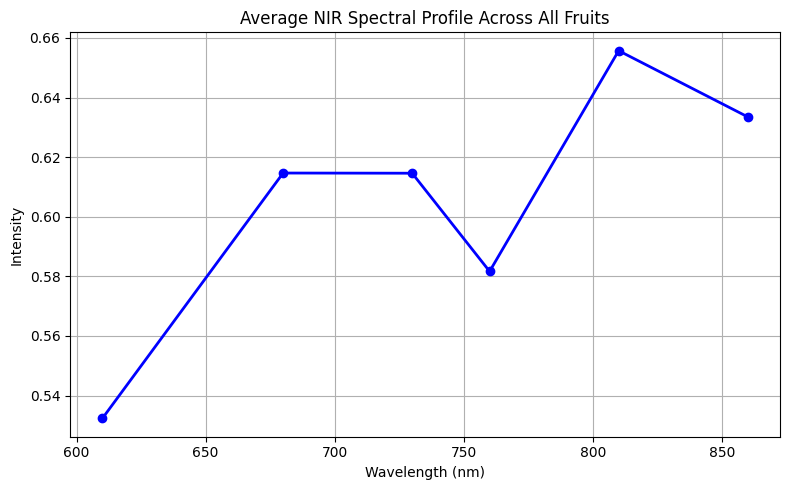

In [3]:
# Các cột phổ
wavelengths = ['610nm', '680nm', '730nm', '760nm', '810nm', '860nm']
wavelength_vals = [610, 680, 730, 760, 810, 860]

# Tính trung bình cường độ tại mỗi bước sóng
mean_vals = df[wavelengths].mean()

# Vẽ biểu đồ phổ trung bình
plt.figure(figsize=(8, 5))
plt.plot(wavelength_vals, mean_vals, marker='o', linewidth=2, color='blue')
plt.title('Average NIR Spectral Profile Across All Fruits')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Preprocessing

In [4]:
# 1. Đặc trưng phổ NIR (6 bước sóng)
wavelengths = ['610nm', '680nm', '730nm', '760nm', '810nm', '860nm']

# 2. One-hot encode cột 'fruit'
df = pd.get_dummies(df, columns=['fruit'])  # Tạo fruit_apple, fruit_mango, fruit_banana
fruit_features = ['fruit_apple', 'fruit_mango', 'fruit_banana']

# 3. Tạo đầu vào X: gồm phổ + one-hot fruit → (9 đặc trưng)
X_raw = df[wavelengths + fruit_features].values

# 4. Đầu ra liên tục (regression)
y_reg = df[['brix', 'ripeness', 'moisture']].values

# 5. Đầu ra phân loại
y_cat = df[['grade', 'defect', 'fungus']].copy()

# 6. One-hot encode 'grade'
enc = OneHotEncoder(sparse_output=False)
y_grade = enc.fit_transform(y_cat[['grade']])

# 7. Encode nhị phân cho 'defect' và 'fungus'
y_defect = y_cat['defect'].astype(int).values
y_fungus = y_cat['fungus'].astype(int).values

# 8. Scale đầu vào và reshape (samples, 9, 1) cho CNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_cnn = X_scaled.reshape(-1, 9, 1)  # ← Bây giờ có 9 đặc trưng đầu vào

# 9. Train-test split
X_train, X_test, y_reg_train, y_reg_test, y_grade_train, y_grade_test, y_def_train, y_def_test, y_fun_train, y_fun_test = train_test_split(
    X_cnn, y_reg, y_grade, y_defect, y_fungus, test_size=0.2, random_state=42
)

print('Data shapes:')
print('X_train:', X_train.shape)
print('y_reg_train:', y_reg_train.shape)
print('y_grade_train:', y_grade_train.shape)

Data shapes:
X_train: (720, 9, 1)
y_reg_train: (720, 3)
y_grade_train: (720, 3)


## 3. Build Model

In [5]:

# Đầu vào: 9 đặc trưng gồm 6 bước sóng + 3 loại quả, reshape thành (9, 1)
inp = Input((9, 1))  # (số đặc trưng, 1)

# 🧠 Tầng Conv1D: học mối quan hệ giữa các đặc trưng (bước sóng + loại quả)
x = Conv1D(16, kernel_size=2, activation='relu')(inp)  # (None, 8, 16)

# 📉 Làm phẳng đầu ra Conv1D
x = Flatten()(x)  # (None, 128)

# 🔗 MLP layers
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

# 🎯 Đầu ra hồi quy: °Brix, độ chín, độ ẩm
reg_out = Dense(3, name='regression')(x)

# 🎯 Đầu ra phân loại đa lớp: grade (A/B/C)
grade_out = Dense(3, activation='softmax', name='grade')

# 🎯 Đầu ra nhị phân: defect và fungus
def_out = Dense(1, activation='sigmoid', name='defect')(x)
fun_out = Dense(1, activation='sigmoid', name='fungus')(x)

# 🔗 Kết hợp tất cả các nhánh
model = Model(inputs=inp, outputs=[reg_out, grade_out(x), def_out, fun_out])

## 4. Compile Model

In [6]:
# ⚙️ Compile
model.compile(
    optimizer='adam',
    loss={
        'regression': 'mse',
        'grade': 'categorical_crossentropy',
        'defect': 'binary_crossentropy',
        'fungus': 'binary_crossentropy'
    },
    metrics={
        'regression': 'mae',
        'grade': 'accuracy',
        'defect': 'accuracy',
        'fungus': 'accuracy'
    }
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 16)     │         48 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 3)         │         51 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grade (Dense)       │ (None, 3)         │         51 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defect (Dense)      │ (None, 1)         │         17 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fungus (Dense)      │ (None, 1)         │         17 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,840 (18.91 KB)

 Trainable params: 4,840 (18.91 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train & Plot Learning Curves

Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - defect_accuracy: 0.1862 - defect_loss: 0.8061 - fungus_accuracy: 0.4343 - fungus_loss: 0.7199 - grade_accuracy: 0.2778 - grade_loss: 1.1949 - loss: 2304.8257 - regression_loss: 2302.1050 - regression_mae: 34.6394 - val_defect_accuracy: 0.1222 - val_defect_loss: 1.0216 - val_fungus_accuracy: 0.7833 - val_fungus_loss: 0.5969 - val_grade_accuracy: 0.2389 - val_grade_loss: 1.1590 - val_loss: 2039.0383 - val_regression_loss: 2036.9242 - val_regression_mae: 32.5626
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - defect_accuracy: 0.1596 - defect_loss: 0.9687 - fungus_accuracy: 0.8410 - fungus_loss: 0.5180 - grade_accuracy: 0.3522 - grade_loss: 1.4091 - loss: 1819.4863 - regression_loss: 1816.5907 - regression_mae: 30.9865 - val_defect_accuracy: 0.8778 - val_defect_loss: 0.3703 - val_fungus_accuracy: 0.7833 - val_fungus_loss: 0.6451 - val_grade_accuracy: 0.4833 - val_grade_loss: 1.0650 - val_loss: 906.4536 - val_regression_loss: 905.5864

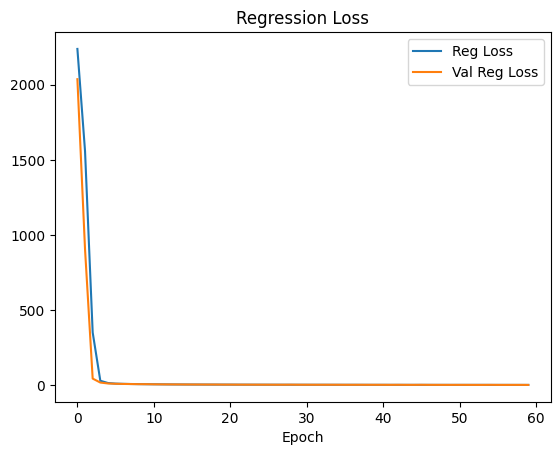

In [7]:
history = model.fit(
    X_train, [y_reg_train, y_grade_train, y_def_train, y_fun_train],
    validation_data=(X_test, [y_reg_test, y_grade_test, y_def_test, y_fun_test]),
    epochs=60, batch_size=16
)
plt.figure()
plt.plot(history.history['regression_loss'], label='Reg Loss')
plt.plot(history.history['val_regression_loss'], label='Val Reg Loss')
plt.title('Regression Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

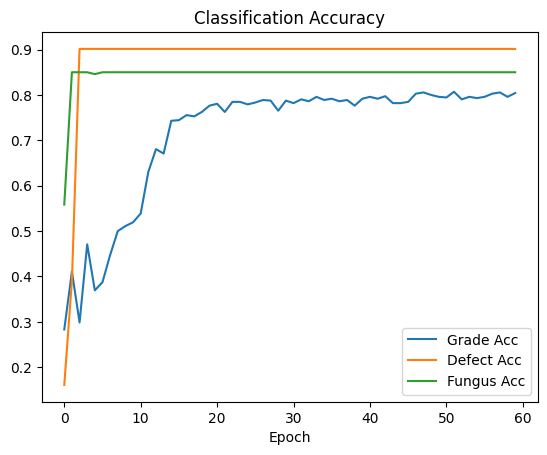

In [8]:
plt.figure()
plt.plot(history.history['grade_accuracy'], label='Grade Acc')
plt.plot(history.history['defect_accuracy'], label='Defect Acc')
plt.plot(history.history['fungus_accuracy'], label='Fungus Acc')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

##6 test thủ công số liệu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
🎯 Inference Result for Manual Input
────────────────────────────────────────────
📌 Predicted Brix (°Bx):      14.88
📌 Predicted Ripeness:        6.81/10
📌 Predicted Moisture (%):    67.68

🏷️ Grade Prediction:          A → Confidence: 81.86%
⚠️ Internal Defect:           No → Confidence: 11.31%
🍄 Fungus Infection:          No → Confidence: 14.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


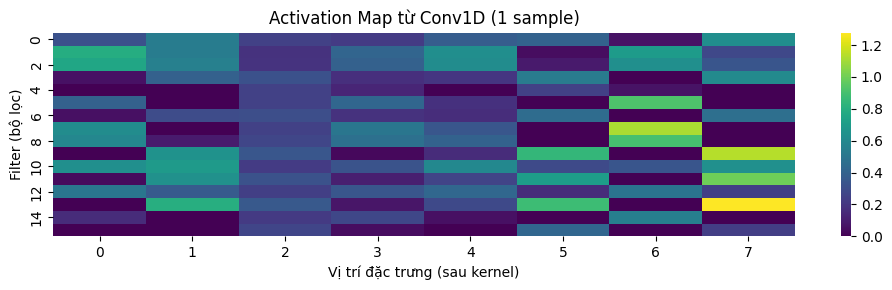

In [26]:


# 📥 Nhập thủ công vector NIR + one-hot fruit
manual_input = np.array([[ 
    0.43,  # 610nm
    0.48,  # 680nm
    0.52,  # 730nm
    0.46,  # 760nm
    0.72,  # 810nm
    0.40,  # 860nm
    0,     # fruit_apple
    0,     # fruit_mango
    1      # fruit_banana
]])

# ✅ Reshape để phù hợp input shape (batch_size, 9, 1)
manual_input = manual_input.reshape((1, 9, 1))

# 🚀 Dự đoán từ model
pred_reg, pred_grade, pred_defect, pred_fungus = model.predict(manual_input)

# 🧾 In kết quả rõ ràng
grade_map = {0: 'A', 1: 'B', 2: 'C'}

print("🎯 Inference Result for Manual Input")
print("────────────────────────────────────────────")
print(f"📌 Predicted Brix (°Bx):      {pred_reg[0][0]:.2f}")
print(f"📌 Predicted Ripeness:        {pred_reg[0][1]:.2f}/10")
print(f"📌 Predicted Moisture (%):    {pred_reg[0][2]:.2f}")
print()
print(f"🏷️ Grade Prediction:          {grade_map[np.argmax(pred_grade[0])]} → Confidence: {np.max(pred_grade[0]):.2%}")
print(f"⚠️ Internal Defect:           {'Yes' if pred_defect[0][0] > 0.5 else 'No'} → Confidence: {pred_defect[0][0]:.2%}")
print(f"🍄 Fungus Infection:          {'Yes' if pred_fungus[0][0] > 0.5 else 'No'} → Confidence: {pred_fungus[0][0]:.2%}")




# ⚙️ Dùng layer Conv1D đầu tiên làm feature extractor
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv1d').output)
X_all = X_scaled.reshape(-1, 9, 1)

# 🧪 Lấy 1 sample bất kỳ từ X_all (đã gồm 6 bước sóng + 3 fruit = 9 đặc trưng)
sample = X_all[0:1]  # shape: (1, 9, 1)

# 🚀 Dự đoán đặc trưng từ Conv1D
features = feature_extractor.predict(sample)

# 📊 Vẽ heatmap biểu diễn đặc trưng trích xuất
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
sns.heatmap(features[0].T, cmap='viridis', xticklabels=range(features.shape[1]))
plt.title("Activation Map từ Conv1D (1 sample)")
plt.xlabel("Vị trí đặc trưng (sau kernel)")
plt.ylabel("Filter (bộ lọc)")
plt.tight_layout()
plt.show()


## 7. Evaluate & Save Model

In [24]:
model.evaluate(X_test, [y_reg_test, y_grade_test, y_def_test, y_fun_test])
model.save('nir_model_v3.h5')
print('Saved as nir_model_v3.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - defect_accuracy: 0.8779 - defect_loss: 0.3794 - fungus_accuracy: 0.7845 - fungus_loss: 0.6294 - grade_accuracy: 0.7450 - grade_loss: 0.4436 - loss: 5.0199 - regression_loss: 3.5665 - regression_mae: 1.4132 


Saved as nir_model_v3.h5
